In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet, RidgeCV, LassoCV, HuberRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor


%matplotlib inline
plt.style.use('ggplot')

In [2]:
str_to_ndarray = lambda x: np.fromstring(x, sep=' ')

path = os.path.join('..', '..', '..', 'data', 'KG_combin.csv')
kg_data = pd.read_csv(path, converters={'eigvals': str_to_ndarray})

for q in range(14):#nondeg_minlen):
    kg_data['omega2_' + str(q)] = kg_data['eigvals'].apply(lambda arr: arr[6 + q]) / kg_data['rho']

kg_data = kg_data.drop(columns=['eigvals'])

In [3]:
kg_data

,K,G,rho,dx,dy,dz,shape,omega2_0,omega2_1,omega2_2,...,omega2_4,omega2_5,omega2_6,omega2_7,omega2_8,omega2_9,omega2_10,omega2_11,omega2_12,omega2_13
0,0.3,0.300000,0.2,0.1,0.1,0.1,cone,363.812512,363.812512,616.861943,...,801.530462,1202.741616,1202.741616,1360.593158,1360.593158,1391.954446,1391.954446,1598.471054,1598.471054,2043.801060
1,0.3,1.057143,0.2,0.1,0.1,0.1,cone,1080.357105,1237.165522,1237.165522,...,2651.506483,2768.883511,2768.883511,3218.011759,3218.011759,3335.602641,4738.235859,4738.235859,4917.977790,4917.977790
2,0.3,1.814286,0.2,0.1,0.1,0.1,cone,1279.463309,2075.013838,2075.013838,...,3628.548353,3628.548353,3915.845931,3915.845931,4683.416721,4683.416721,6711.904416,6711.904416,8050.533407,8050.533407
3,0.3,2.571429,0.2,0.1,0.1,0.1,cone,1402.145793,2886.110200,2886.110200,...,4161.645389,4161.645389,4597.790620,4597.790620,6539.611577,6539.611577,7540.838290,7540.838290,10185.591908,11261.941102
4,0.3,3.328571,0.2,0.1,0.1,0.1,cone,1488.362993,3668.498967,3668.498967,...,4360.684462,4360.684462,5436.294393,5436.294393,8067.005188,8067.005188,8300.251487,8300.251487,11831.588014,12960.953559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229371,5.6,2.571429,10.0,1.0,1.0,1.0,tetrahedron,1.776489,1.992767,1.992767,...,2.899190,4.501326,4.501326,4.935697,6.125115,7.256192,8.070548,8.070548,9.253246,9.253246
229372,5.6,3.328571,10.0,1.0,1.0,1.0,tetrahedron,2.213418,2.533433,2.533433,...,3.643310,5.720904,5.720904,6.363125,7.760717,9.045892,10.325101,10.325101,11.806433,11.806433
229373,5.6,4.085714,10.0,1.0,1.0,1.0,tetrahedron,2.618126,3.053709,3.053709,...,4.345456,6.901332,6.901332,7.772311,9.335054,10.704454,12.520110,12.520110,14.275421,14.275421
229374,5.6,4.842857,10.0,1.0,1.0,1.0,tetrahedron,2.993823,3.554073,3.554073,...,5.009227,8.046839,8.046839,9.157921,10.858081,12.246230,14.653307,14.653307,16.657100,16.657100


In [4]:
kg_data.describe()

,K,G,rho,dx,dy,dz,omega2_0,omega2_1,omega2_2,omega2_3,omega2_4,omega2_5,omega2_6,omega2_7,omega2_8,omega2_9,omega2_10,omega2_11,omega2_12,omega2_13
count,229376.000000,229376.000000,229376.00000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000,229376.000000
mean,2.950000,2.950000,5.10000,0.550000,0.550000,0.550000,16.739605,21.135301,29.400836,38.416714,43.440930,56.009073,63.434483,73.168343,82.680376,93.990011,106.735759,118.497855,130.753480,147.398284
std,1.734836,1.734836,3.20781,0.335411,0.335411,0.335411,244.939548,280.497560,311.576806,390.258233,405.425383,571.308483,585.890450,658.166163,734.950312,811.871114,947.115324,1000.957883,1080.317414,1170.758644
min,0.300000,0.300000,0.20000,0.100000,0.100000,0.100000,0.000573,0.001144,0.001523,0.001617,0.001617,0.004007,0.004068,0.004068,0.004340,0.004583,0.008234,0.008234,0.008451,0.010091
25%,1.625000,1.625000,2.65000,0.325000,0.325000,0.325000,0.168137,0.324871,0.616261,0.883725,1.112209,1.519709,1.815547,2.160974,2.510211,2.915856,3.277505,3.695340,4.126307,4.599428
50%,2.950000,2.950000,5.10000,0.550000,0.550000,0.550000,0.726890,1.218669,2.082306,2.921906,3.559819,4.524181,5.395988,6.417707,7.410528,8.518543,9.615115,10.841507,12.169902,13.558143
75%,4.275000,4.275000,7.55000,0.775000,0.775000,0.775000,2.971973,4.494399,7.267567,10.135608,12.260153,15.267813,18.403322,21.759045,24.983601,28.712587,32.700292,37.038674,41.584701,46.774784
max,5.600000,5.600000,10.00000,1.000000,1.000000,1.000000,17515.860279,20175.426828,20175.426828,28189.091978,28189.091978,45806.017618,45806.017618,52567.315780,61703.654454,68420.943009,83612.587834,83612.587834,94746.893083,94746.893084


# Huber with Power Transform

In [ ]:
# Separación de features y target
X = kg_data.drop(['K', 'G'], axis=1)
y = kg_data['K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) #, random_state=1)

sqrt_columns = ['rho', 'dx', 'dy', 'dz']
omega_columns = [f'omega2_{i}' for i in range(14)]
categorical_columns = ['shape']

# Creación del pipeline con ElasticNetCV
elasticnet_cv = ElasticNetCV(fit_intercept=True, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, max_iter=100000, n_jobs=-1)

# Combina las columnas numéricas para aplicar PowerTransformer a todas ellas
numeric_columns = sqrt_columns + omega_columns

# Aplica PowerTransformer a todas las columnas numéricas
feature_transformer = ColumnTransformer(transformers=[
    ('power', PowerTransformer(method='yeo-johnson'), numeric_columns),
    ('onehot', OneHotEncoder(drop='first'), categorical_columns)
], remainder='drop')

# Agrega PolynomialFeatures para las interacciones y potencias
polynomial_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Creación del pipeline con ElasticNetCV y PolynomialFeatures
pipeline = Pipeline(steps=[
    ('feature_transformation', feature_transformer),
    ('polynomial', polynomial_transformer),  # Agrega las interacciones y potencias de las features
    ('scaling', MinMaxScaler()),
    ('regression', HuberRegressor(fit_intercept=True, max_iter=10000, alpha=0.0001, epsilon=1))
])


# TransformedTargetRegressor para transformar la variable objetivo (np.sqrt(K))
model = TransformedTargetRegressor(regressor=pipeline, func=np.sqrt, inverse_func=np.square)

model.fit(X_train, y_train)

# Predice los valores automáticamente con la transformación inversa
y_pred = model.predict(X_test)

# Métricas sobre los datos originales
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.3f}')

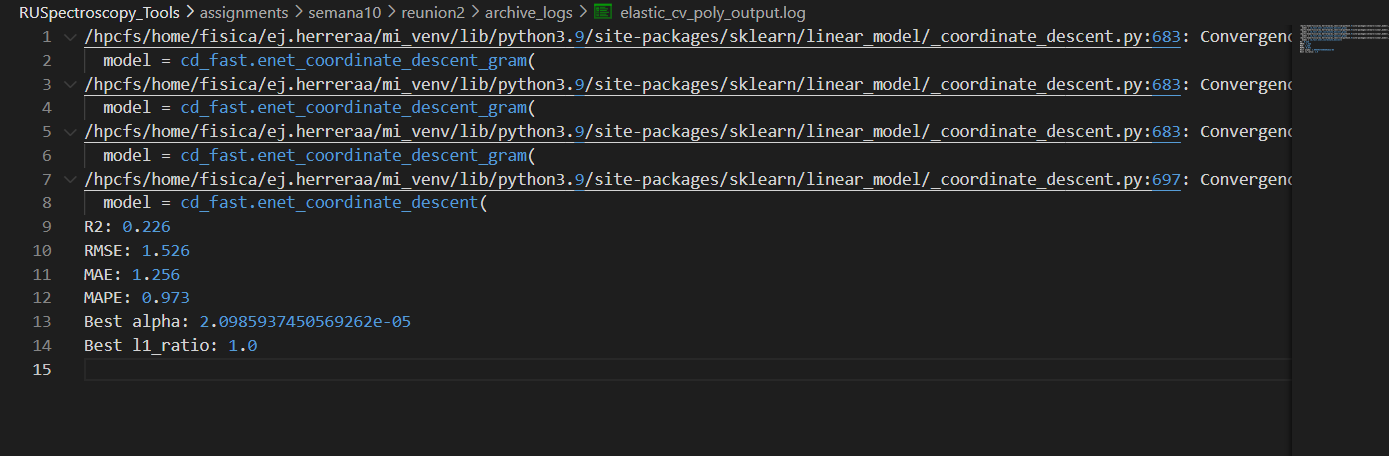

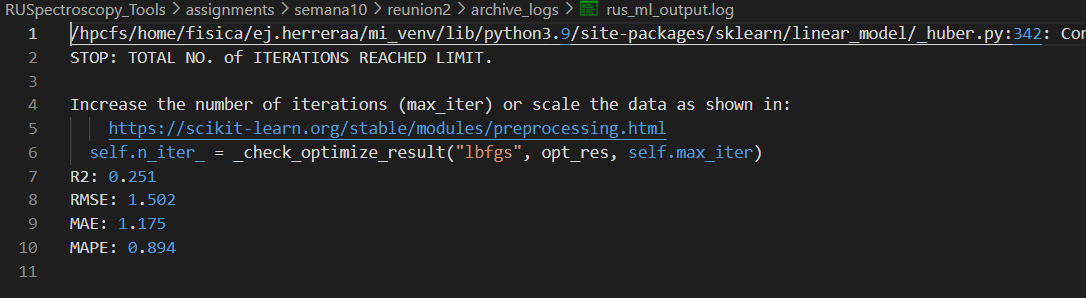